In [1]:
# Thats our five classes
from labeling.emotions import rage, joy, sadness, surprise, fear, all_flag_words

In [2]:
xd = 20000

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('data/processed_comments_1.csv', nrows = xd)

In [6]:
comments = df['words'].str.strip('[]').str.replace("'", '').str.split(',').values

In [7]:
strip_com = []
for comment in comments:
    strip_tmp = []
    for word in comment:
        strip_tmp.append(word.strip())
    strip_com.append(strip_tmp)

In [8]:
comments = strip_com

In [9]:
urls = df['url'].values

### Calculate log TF-IDF
https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [10]:
words = [word for com_list in [com for com in comments] for word in com_list]

In [11]:
from collections import Counter

In [12]:
word_freq = dict(Counter(words))

In [13]:
# I do not need words which occur in the whole document just once or two
word_freq_filter = {word: freq for word, freq in word_freq.items() if freq > round(xd*0.001) or word in all_flag_words}.keys()

In [14]:
unique_words = word_freq_filter

In [15]:
vocab_size = len(unique_words)

In [16]:
vocab_size

2285

In [17]:
word2int = {}
int2word = {}
for i,word in enumerate(unique_words):
    word2int[word] = i
    int2word[i] = word

In [18]:
comments_tf_idf = []
labels = []

for comment in comments:
    tmp_vec = np.zeros(vocab_size)
    tmp_labels = np.zeros(5)
    
    tmp_word_freq = dict(Counter(comment))
    for word, count in tmp_word_freq.items():
        # for each comment calculate
        
        # label
        for i, emotion in enumerate([rage, joy, sadness, surprise, fear]):
            for flag_word in emotion:
                if word == flag_word:
                    tmp_labels[i] += 1
        
        # and vector with tf-idf features
        if word in word_freq_filter:
            tmp_vec[word2int[word]] = np.log(1 + count / word_freq[word])
    comments_tf_idf.append(tmp_vec)
    # sqrt to soften labels where there was a lot of emotions
    labels.append(np.sqrt(tmp_labels))

In [19]:
del comments

In [20]:
x = np.asarray(comments_tf_idf)
y = np.asarray(labels)

In [21]:
del comments_tf_idf
del labels

In [22]:
print(x.shape, y.shape)

(20000, 2285) (20000, 5)


### Modeling

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.nn import relu

In [24]:
model = Sequential([
    Dense(vocab_size/50, activation=relu, input_shape=[vocab_size]),
    Dense(vocab_size/50, activation=relu),
    Dense(5)
])

W0624 20:45:21.718288 140385189427008 deprecation.py:506] From /home/jacek/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [25]:
from tensorflow.keras.optimizers import RMSprop

In [26]:
optimizer = RMSprop(0.003)

In [27]:
model.compile(
    loss='mean_squared_error',
    optimizer=optimizer,
    metrics=['mean_absolute_error']
)

In [28]:
b = int(0.8 * len(x))

In [29]:
train_x = x[:b]
train_y = y[:b]

test_x = x[b:]
test_y = y[b:]

In [30]:
del x
del y

In [31]:
example_batch = test_x[:2]
print(model.predict(example_batch))

[[ 4.9589266e-04  1.7207773e-05  3.8272803e-04 -2.0513443e-04
  -3.8568505e-05]
 [ 1.7561684e-03 -7.9847923e-05  2.1354892e-04 -1.2549100e-03
   4.5660147e-04]]


In [32]:
EPOCHS = 200

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=25)

In [35]:
history = model.fit(
    train_x, train_y,
    epochs=EPOCHS, 
    validation_split = 0.2, 
    verbose=0,
    callbacks=[early_stop]
)

In [36]:
from datetime import datetime as dt

In [37]:
model.save('models/all_data'+dt.now().date().strftime('%Y_%m_%d'))

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    m = max(max([history.history['mean_absolute_error'] + history.history['val_mean_absolute_error']]))
    plt.ylim([0,m * 1.1])
    plt.legend()

In [40]:
loss, mae = model.evaluate(test_x, test_y, verbose=0)

In [41]:
mae

0.006543288

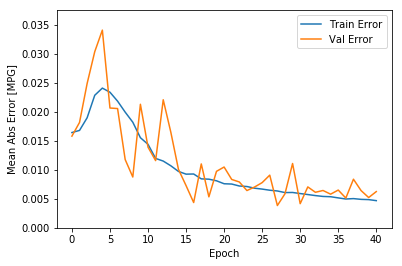

In [42]:
plot_history(history)

In [43]:
pred = model.predict(test_x)

In [44]:
res = pd.concat([pd.DataFrame(pred), pd.DataFrame(test_y)], axis = 1)

In [45]:
res.columns = ['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5',
               'real_1', 'real_2', 'real_3', 'real_4', 'real_5']

In [46]:
res[res['real_3'] != 0].head(10)

,pred_1,pred_2,pred_3,pred_4,pred_5,real_1,real_2,real_3,real_4,real_5
119,-0.014421,0.066199,0.144626,-0.005577,0.016024,0.0,0.0,1.0,0.0,0.0
125,-0.014421,0.066199,0.144626,-0.005577,0.016024,0.0,0.0,1.0,0.0,0.0
263,-0.019377,0.000908,1.097227,-0.004275,-0.008005,0.0,0.0,1.0,0.0,0.0
273,-0.010034,0.001600,0.710902,-0.016988,-0.004224,0.0,0.0,1.0,0.0,0.0
440,-0.026382,0.013662,0.892707,-0.002564,-0.006373,0.0,0.0,1.0,0.0,0.0
462,-0.012013,-0.001367,1.036732,-0.013936,-0.005480,0.0,0.0,1.0,0.0,0.0
611,0.014703,0.114243,0.289973,-0.006271,-0.008956,0.0,0.0,1.0,0.0,0.0
651,-0.015793,-0.001679,1.090519,-0.008724,-0.006877,0.0,0.0,1.0,0.0,0.0
661,-0.002502,-0.001907,0.910853,-0.018741,-0.003458,0.0,0.0,1.0,0.0,0.0
790,-0.016349,0.001087,1.053363,-0.008127,-0.006981,0.0,0.0,1.0,0.0,0.0
